# CREDIT SCORECARD WITH LOAN_DATA_2015 DATASET

## 1. Import libraries

In [1]:
import os
from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import iqr
from feature_engine.encoding import WoEEncoder as woe
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import statsmodels.api as sm
from statsmodels.api import Logit
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip freeze > requirements.txt

In [3]:
# Dev simple functions
# Tính tỷ lệ giá trị khuyết thiếu
def calculate_missing_percentage(df=pd.DataFrame()):
    missing_value_percentage = []
    for col in df.columns:
        missing_value_percentage.append((col, df[col].isnull().sum() / len(df)))
    missing_value_percentage = sorted(missing_value_percentage, key=lambda x: x[1], reverse=True)
    missing_value_percentage = pd.DataFrame(missing_value_percentage, columns=['Feature', 'Missing Value Percentage'])
    return missing_value_percentage
# Vẽ box_plot
def plot_boxplot(df, column):
    plt.figure(figsize=(20, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()
# Vẽ histogram
def plot_histogram(df, column):
    plt.figure(figsize=(20, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
# Vẽ biểu đồ phân tán
def plot_scatter(df, x_column, y_column, z_column=None):
    if z_column:
        plt.figure(figsize=(20, 6))
        sns.scatterplot(x=df[x_column], y=df[y_column], hue=df[z_column])
        plt.title(f'Scatter Plot of {x_column} vs {y_column} colored by {z_column}')
        plt.xlabel(x_column)
        plt.ylabel(y_column)
        plt.legend(title=z_column)
        plt.show()
    else:
        if x_column == y_column:
            raise ValueError("x_column and y_column cannot be the same for a scatter plot.")
# Convert date columns to datetime format
def date_convert(df, column):
    df[column] = pd.to_datetime(df[column], format='%b-%y')
# Vẽ biểu đồ cột
def plot_bar(df, column):
    plt.figure(figsize=(20, 6))
    sns.countplot(x=df[column])
    plt.title(f'Bar Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
# Chuyển đổi cột số tháng thành số nguyên
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))
# Remove outliers using IQR
def remove_outliers_iqr(df, column, times=2.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr_value = iqr(df[column])
    lower_bound = q1 - times * iqr_value
    upper_bound = q3 + times * iqr_value
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
# Mượn các functions vẽ đồ thị
# Biểu đồ histogram
def _plot_hist_subplot(x, fieldname, bins = 10, use_kde = True):
  x = x.dropna()
  xlabel = '{} bins tickers'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'histogram plot of {} with {} bins'.format(fieldname, bins)
  ax = sns.distplot(x, bins = bins, kde = use_kde)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  return ax

# Biểu đồ barchart
def _plot_barchart_subplot(x, fieldname):
  xlabel = 'Group of {}'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'Barchart plot of {}'.format(fieldname)
  x = x.fillna('Missing')
  df_summary = x.value_counts(dropna = False)
  y_values = df_summary.values
  x_index = df_summary.index
  ax = sns.barplot(x = x_index, y = y_values, order = x_index)
  # Tạo vòng for lấy tọa độ đỉnh trên cùng của biểu đồ và thêm label thông qua annotate.
  labels = list(set(x))
  for label, p in zip(y_values, ax.patches):
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.15))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  return ax

## 2. EDA

In [4]:
# Nhập dữ liệu
path = Path.cwd().parent
data_path = path /'data'/'loan_data_2015.csv'
loan_data = pd.read_csv(data_path, low_memory=False)

In [5]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421094 entries, 0 to 421093
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           421094 non-null  int64  
 1   member_id                    421094 non-null  int64  
 2   loan_amnt                    421094 non-null  int64  
 3   funded_amnt                  421094 non-null  int64  
 4   funded_amnt_inv              421094 non-null  int64  
 5   term                         421094 non-null  object 
 6   int_rate                     421094 non-null  float64
 7   installment                  421094 non-null  float64
 8   grade                        421094 non-null  object 
 9   sub_grade                    421094 non-null  object 
 10  emp_title                    397220 non-null  object 
 11  emp_length                   397277 non-null  object 
 12  home_ownership               421094 non-null  object 
 13 

### 2.1. Data Cleaning

In [6]:
# Drop các cột có trên 80% giá trị khuyết thiếu
loan_data.dropna(thresh=loan_data.shape[0]*0.2, axis=1, inplace=True)
# Drop cột policy_code do không có ý nghĩa thống kê
loan_data = loan_data.drop(columns=['policy_code'])

In [7]:
calculate_missing_percentage(loan_data)

,Feature,Missing Value Percentage
0,mths_since_last_major_derog,0.708547
1,mths_since_last_delinq,0.484360
2,next_pymnt_d,0.061167
3,emp_title,0.056695
4,emp_length,0.056560
5,last_pymnt_d,0.041043
6,revol_util,0.000385
7,title,0.000313
8,last_credit_pull_d,0.000026
9,id,0.000000


In [8]:
# Drop các cột không cần thiết bao gồm id, member_id, url, zip_code
loan_data = loan_data.drop(columns=['id', 'member_id', 'url', 'zip_code'])

#### 2.1.1. Clean 'object' columns

In [9]:
# In features dạng object và giá trị unique
cat_cols = loan_data.select_dtypes('object').columns
for col in cat_cols:
    print(col, loan_data[col].nunique())

term 2
grade 7
sub_grade 35
emp_title 120811
emp_length 11
home_ownership 4
verification_status 3
issue_d 12
loan_status 8
pymnt_plan 2
purpose 14
title 27
addr_state 49
earliest_cr_line 668
initial_list_status 2
last_pymnt_d 13
next_pymnt_d 3
last_credit_pull_d 14
application_type 2


In [10]:
# Convert các biến thời gian sang datetime (issue_d, earliest_cr_line, last_pymnt_d, last_credit_pull_d, next_pymnt_d, last_credit_pull_d)
date_convert(loan_data, 'issue_d')
date_convert(loan_data, 'earliest_cr_line')
date_convert(loan_data, 'last_pymnt_d')
date_convert(loan_data, 'last_credit_pull_d')
date_convert(loan_data, 'next_pymnt_d')

In [11]:
# Convert biến 'term' từ text sang số nguyên
loan_term_converter(loan_data, 'term')

In [12]:
# Drop biến grade và sub_grade do đây là xếp hạn tín dụng nội bộ của Lending Club, coi như không có
loan_data = loan_data.drop(columns=['grade', 'sub_grade'])

In [13]:
# Drop biến emp_title do trường thông tin không nhất quán, có thể làm sentiment analysis hoặc xử lý bằng NLP
loan_data = loan_data.drop(columns=['emp_title'])

In [14]:
# Loại dữ liệu có home_ownership giá trị 'ANY' do quá ít dữ liệu (2/~400k lines)
loan_data = loan_data[loan_data['home_ownership'] != 'ANY']

In [15]:
# Loại dữ liệu có application_type là 'JOINT' do cần phân tích dữ liệu KHCN
loan_data = loan_data[loan_data['application_type'] != 'JOINT']
# Drop cột application_type do chỉ có 1 giá trị là 'INDIVIDUAL'
loan_data = loan_data.drop(columns=['application_type'])

In [16]:
# Drop cột title do title của các khoản vay không nhất quán, ngoài ra hầu hết giá trị đều được phản ánh vào purpose
loan_data = loan_data.drop(columns=['title'])

#### 2.1.2. Clean 'int64' columns

In [17]:
cat_cols = loan_data.select_dtypes('int64').columns
for col in cat_cols:
    print(col, loan_data[col].nunique())

loan_amnt 1361
funded_amnt 1361
funded_amnt_inv 1365
term 2
delinq_2yrs 26
inq_last_6mths 7
open_acc 73
pub_rec 28
revol_bal 62065
total_acc 126
collections_12_mths_ex_med 10
acc_now_delinq 8
tot_coll_amt 8346
tot_cur_bal 230145
total_rev_hi_lim 10692


Features included:
- **Information about current loan:** loan_amnt, funded_amnt, funded_amnt_inv, term
- **Customers' credit history:** delinq_2yrs, inq_last_6mths, open_acc, pub_rec, revol_bal, total_acc, acc_now_delinq, tot_cur_bal, total_rev_hi_lim
- **Customers' behavior with current loan:** collections_12_mths_ex_med, tot_coll_amt

In [18]:
# Các biến loan_amnt, funded_amnt, funded_amnt_inv có giá trị gần giống nhau trong đó loan_amount là giá trị khoản vay ban đầu, 
# funded_amnt là số tiền đã được giải ngân, funded_amnt_inv là số tiền đã được đầu tư bởi các investors trên nền tảng LC. Chỉ giữ lại funded_amnt.
loan_data = loan_data.drop(columns=['loan_amnt', 'funded_amnt_inv'])

In [19]:
# Kiểm tra phân phối và giá trị distinct của biến delinq_2yrs, nhận thấy có 79,32% giá trị là 0, chuyển biến này thành nhị phân (có lịch sử trả chậm trong 2 năm gần nhất hay không?)
# sns.boxplot(x=loan_data['delinq_2yrs'])
# plot_bar(loan_data, 'delinq_2yrs')
# loan_data[loan_data['delinq_2yrs'] == 0].shape[0] / loan_data.shape[0] 
loan_data['delinq_2yrs'] = loan_data['delinq_2yrs'].apply(lambda x: 1 if x > 0 else 0)

In [20]:
# open_acc là số tài khoản đang ở trạng thái mở của khách hàng, total_acc là tổng số tài khoản đã mở trong quá khứ, kiểm tra lại logic dữ liệu open_acc <= total_acc
# invalid_open_acc = (loan_data['open_acc'] > loan_data['total_acc']).sum()
# print(f"open_acc > total_acc: {invalid_open_acc}")
# Chỉ giữ lại total_acc
loan_data = loan_data.drop(columns=['open_acc'])

In [21]:
# Drop biến pub_rec do > 80% quan sát tập trung vào giá trị 0
# loan_data[loan_data['pub_rec'] == 0].shape[0] / loan_data.shape[0]
loan_data = loan_data.drop(columns=['pub_rec'])

In [22]:
# Kiểm tra correlation giữa các biến revol_bal, tot_rev_hi_lim, tot_cur_bal cho thấy có sự tương quan cao, giữ lại revol_bal và total_rev_hi_lim do high_limit là giới hạn
# tín dụng cao nhất của khách hàng.
# sns.heatmap(loan_data[['revol_bal', 'total_rev_hi_lim', 'tot_cur_bal', ]].corr(), annot=True, cmap='coolwarm')
loan_data = loan_data.drop(columns=['tot_cur_bal'])

In [23]:
# Kiểm tra biến acc_now_delinq có trên 90% dữ liệu tập trung ở giá trị 0, drop
# plot_bar(loan_data,'acc_now_delinq')
loan_data = loan_data.drop(columns=['acc_now_delinq'])

In [24]:
# Drop các biến hành vi với khoản vay hiện tại do các hành vi này chỉ xuất hiện sau khi đã được duyệt vay, nằm ngoài scope của A-score
loan_data = loan_data.drop(columns=['collections_12_mths_ex_med', 'tot_coll_amt'])

#### 2.1.3. Clean 'float64' columns

In [25]:
cat_cols = loan_data.select_dtypes('float64').columns
for col in cat_cols:
    print(col, loan_data[col].nunique())

int_rate 110
installment 40415
annual_inc 26850
dti 4000
mths_since_last_delinq 140
revol_util 1211
out_prncp 119492
out_prncp_inv 132562
total_pymnt 174068
total_pymnt_inv 183262
total_rec_prncp 105344
total_rec_int 129409
total_rec_late_fee 812
recoveries 305
collection_recovery_fee 300
last_pymnt_amnt 67193
mths_since_last_major_derog 162


Features included:
- **Information about current loan:** int_rate, installment, term
- **Customers' Demographic:** annual_inc, dti
- **Customers' credit history:** mths_since_last_delinq, revol_util, mths_since_last_major_derog 
- **Customers' behavior with current loan:** out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_amnt

In [26]:
# Drop int_rate, installment
loan_data = loan_data.drop(columns=['int_rate', 'installment'])

In [27]:
# Drop các biến hành vi với khoản vay hiện tại do các hành vi này chỉ xuất hiện sau khi đã được duyệt vay, nằm ngoài scope của A-score
loan_data = loan_data.drop(columns=['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
                                    'collection_recovery_fee', 'last_pymnt_amnt'])

### 2.5. Identify the Dependent Var (loan_status)

**loan_status** included:
- **Fully Paid:** Đã tất toán trước hạn. Vẫn đưa vào mô hình do việc tất toán trước hạn thể hiện khả năng trả nợ tốt của khách hàng, mặc dù gây mất lợi nhuận cho ngân hàng.
- **Current:** Vẫn đang trả nợ đều đặn.
- **Issued**: Được chấp thuận cho vay vào tháng 12/2015, chưa phải trả kỳ nào.
- **In Grace Period:** Quá hạn dưới 15 ngày, chưa bị tính phí phạt trả chậm.
- **Late (16-30 days):** Quá hạn từ 16 đến 30 ngày.
- **Late (31-120 days):** Quá hạn từ 31 đến 120 ngày.
- **Charged Off:** Không còn khả năng trả nợ.
- **Default:** Vỡ nợ.

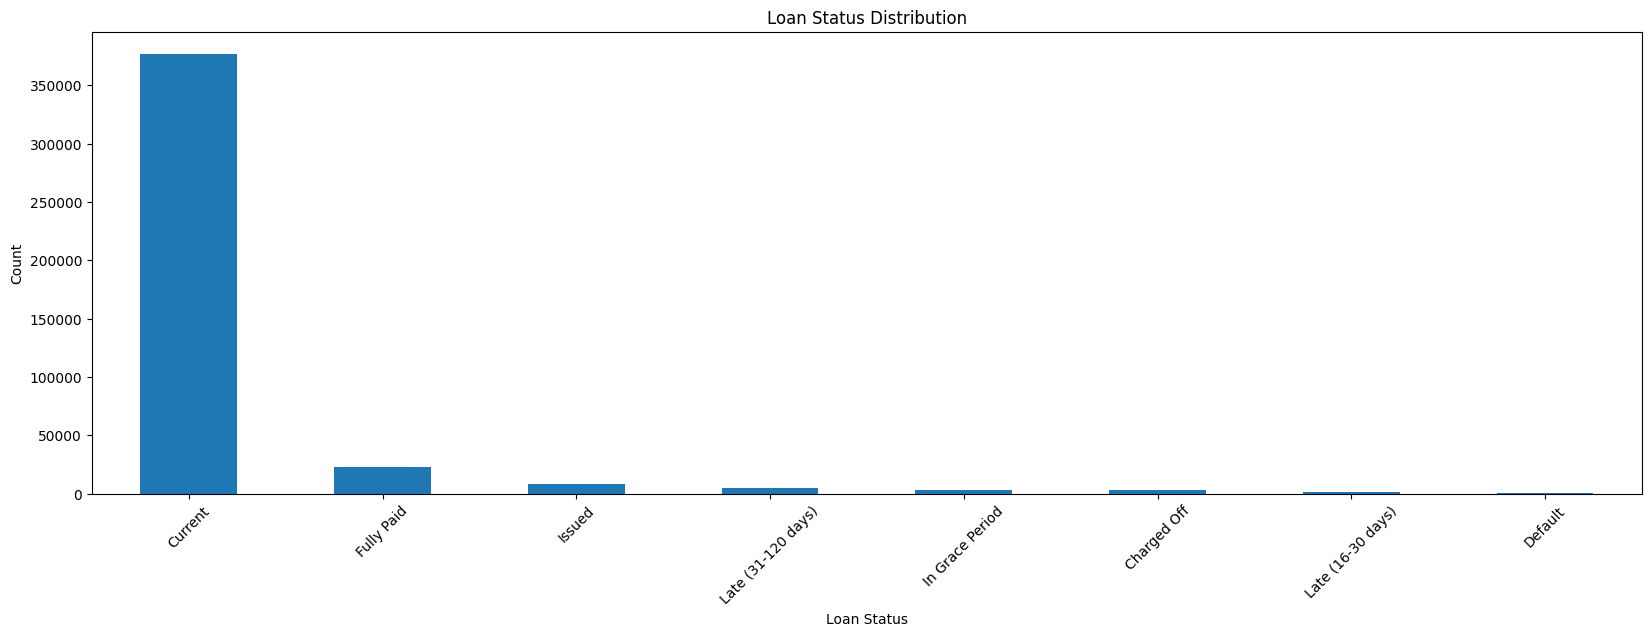

In [28]:
plt.figure(figsize=(20, 6))
loan_data['loan_status'].value_counts().plot(kind='bar')
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

Encode dependent variable:
- **0 - good** (Fully Paid, Current, Issued).
- **1 - bad** (In Grace Period, Late, Charged-off, Default)

In [29]:
loan_data['good_bad'] = np.where(loan_data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period']), 0, 1)
# Drop the original 'loan_status' column
loan_data.drop(columns = ['loan_status'], inplace = True)

In [30]:
# Xác định tỷ lệ good/dataset
loan_data[loan_data['good_bad'] == 1].shape[0] / loan_data.shape[0]

0.9712492956172533

## 3. Analyzing features

### 3.1. Double check data transformation

In [31]:
# Bỏ các biến issue_d, last_pymnt_d, next_pymnt_d, last_credit_pull_d
loan_data.drop(columns = ['issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d'], inplace = True)

In [32]:
# Chuyển earliest_cr_line_year sang số nguyên (số năm tính từ earlies credit line)
loan_data['earliest_cr_line_year'] = loan_data['earliest_cr_line'].dt.year.astype('Int64')
loan_data['years_from_earliest_cr_line'] = 2016 - loan_data['earliest_cr_line_year']
loan_data = loan_data[loan_data['years_from_earliest_cr_line'] >= 0]
# Drop các cột earliest_cr_line, earliest_cr_line_year
loan_data.drop(columns = ['earliest_cr_line', 'earliest_cr_line_year'], inplace = True)

In [33]:
# Xóa các giá trị khuyết thiếu trong emp_length (0.05%)
loan_data = loan_data.dropna(subset=['emp_length'])

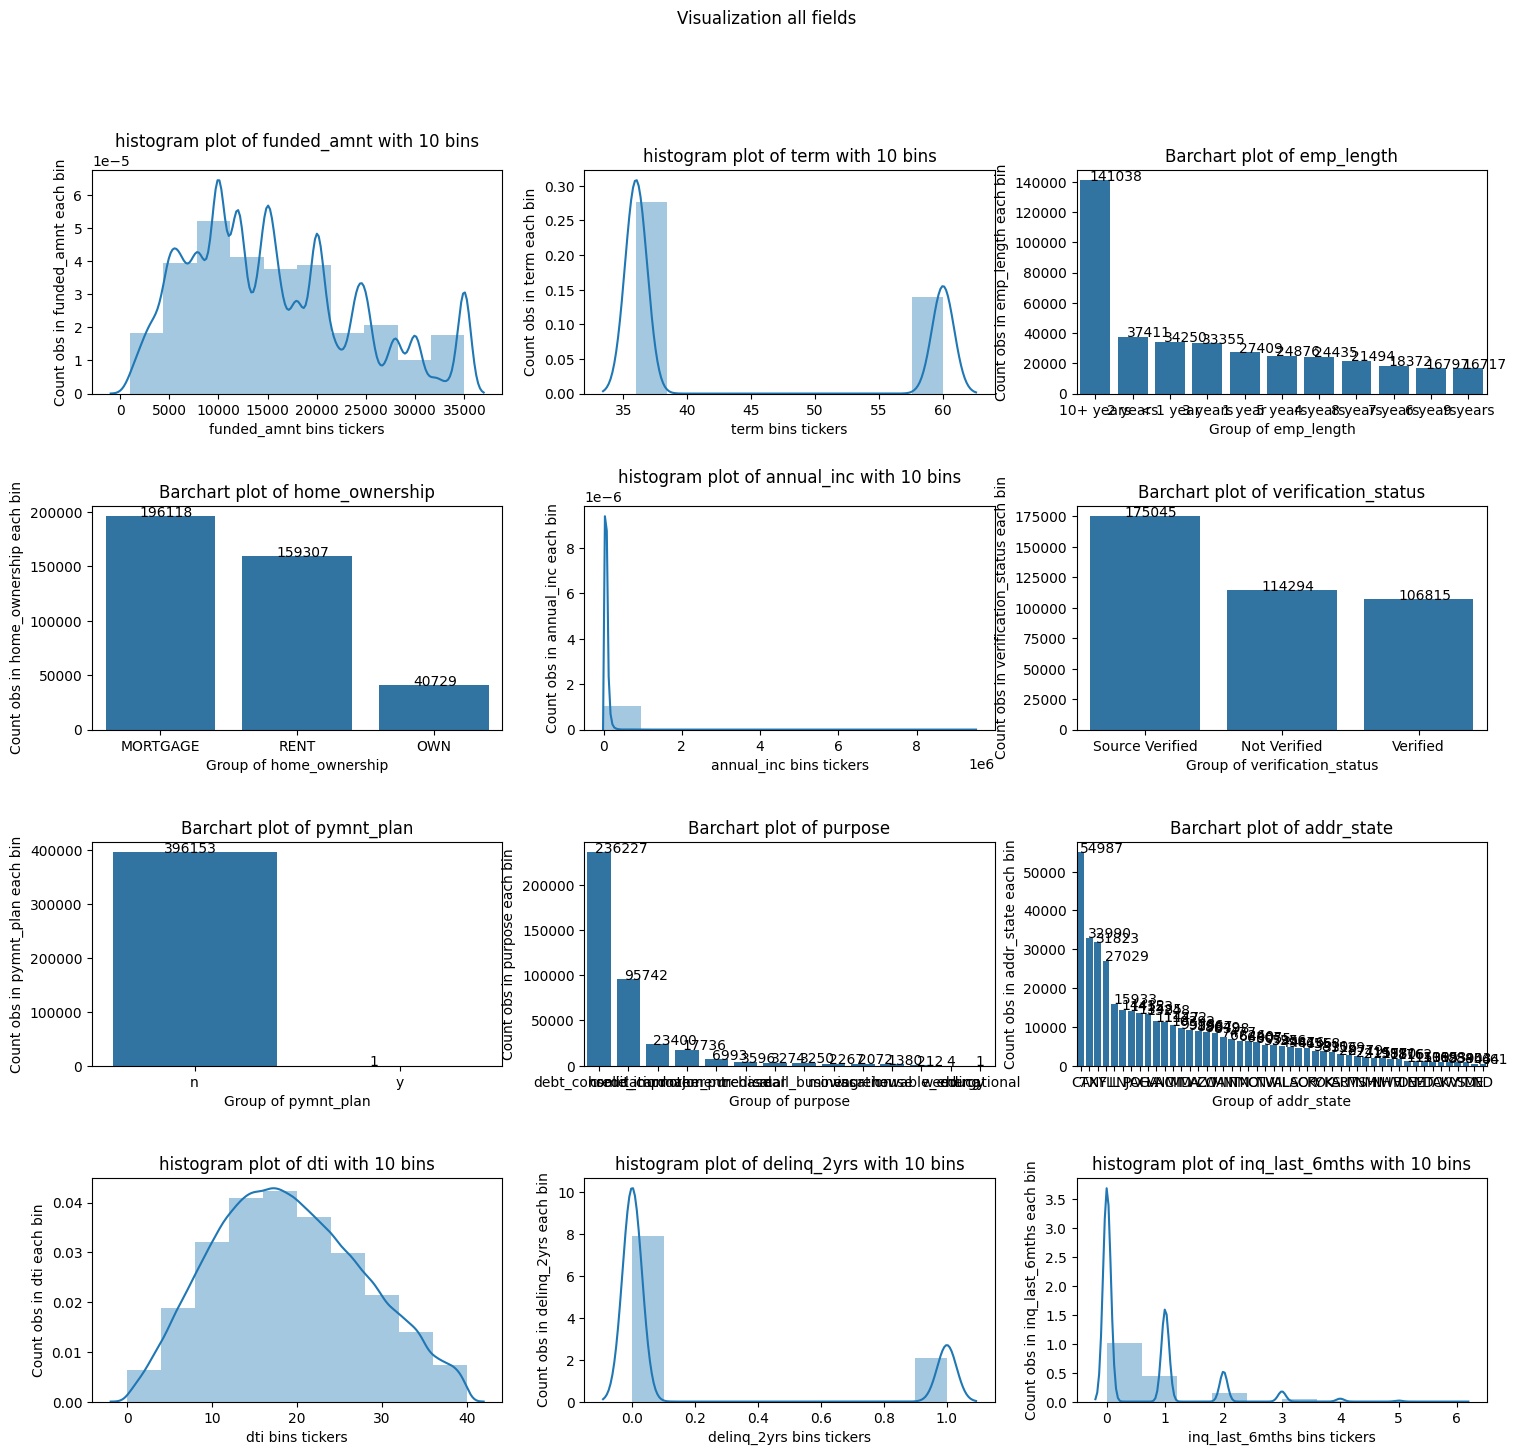

In [34]:
# Khởi tạo figure cho đồ thị (Kích thước W*H = 16x12) và cách nhau là 0.2 giữa các đồ thị
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
# Tạo vòng for check định dạng của biến và visualize
for i, (fieldname, dtype) in enumerate(zip(loan_data.columns, loan_data.dtypes.values)):
  if i <= 11:
    ax_i = fig.add_subplot(4, 3, i+1)
    if dtype in ['float64', 'int64']:
      ax_i = _plot_hist_subplot(loan_data[fieldname], fieldname=fieldname)
    else:
      ax_i = _plot_barchart_subplot(loan_data[fieldname], fieldname=fieldname)
      
fig.suptitle('Visualization all fields')
plt.show()

In [35]:
# Transform term, delinq_2yrs sang dạng categorical
loan_data['term_bin'] = loan_data['term'].map({36: '36m', 60: '60m'})
loan_data.drop(columns = ['term'], inplace = True)

loan_data['delinq_2yrs_bin'] = loan_data['delinq_2yrs'].map({0: 'n', 1: 'y'})
loan_data.drop(columns = ['delinq_2yrs'], inplace = True)

loan_data['inq_last_6mths_bin'] = loan_data['inq_last_6mths'].map({0: 'n', 1: 'y'})
loan_data.drop(columns = ['inq_last_6mths'], inplace = True)

In [36]:
# Drop cột addr_state do quá nhiều bin, tập trung vào Canada
loan_data.drop(columns = ['addr_state'], inplace = True)
# Drop cột mths_since_last_delinq do dữ liệu tập trung vào 0
loan_data.drop(columns = ['mths_since_last_delinq'], inplace = True)

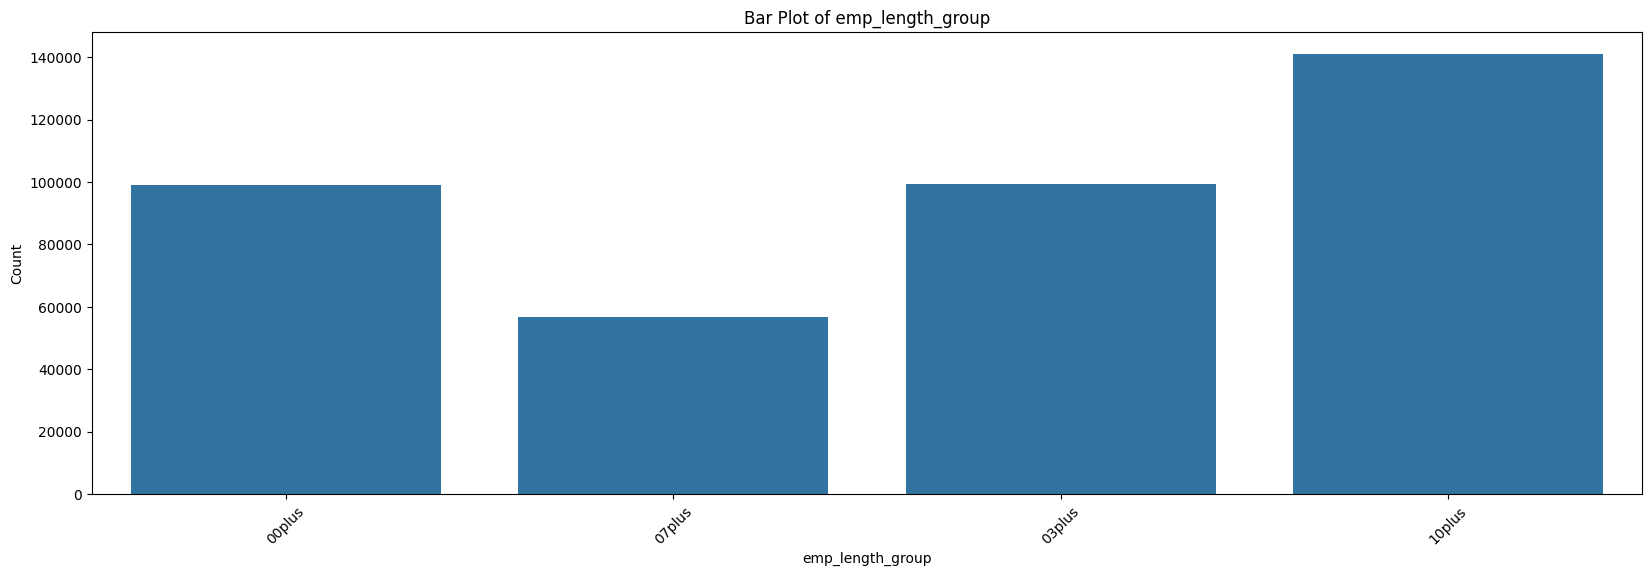

In [37]:
# Recode lại emp_lenght do số lượng dữ liệu tập trung quá nhiều vào 10y+, tách ra làm 3 bin dưới 5, 5-10 và trên 10
def group_emp_length(val):
    if val in ['1 year', '2 years', '< 1 year']:
        return '00plus'
    elif val in ['3 years', '4 years', '5 years', '6 years']:
        return '03plus'
    elif val in ['7 years', '8 years', '9 years', '10 years']:
        return '07plus'
    else:
        return '10plus'

# Tạo biến mới
loan_data['emp_length_group'] = loan_data['emp_length'].apply(group_emp_length)
loan_data.drop(columns = ['emp_length'], inplace = True)

plot_bar(loan_data, 'emp_length_group')

In [38]:
# Recode lại purpose
def group_purpose(val):
    if val == 'debt_consolidation':
        return 'debt_consolidation'
    elif val == 'credit_card':
        return 'credit_card'
    elif val in ['major_purchase', 'car']:
        return 'large_purchase'
    elif val == 'small_business':
        return 'small_business'
    elif val in ['home_improvement', 'house', 'moving']:
        return 'house_related'
    else:
        return 'others'

loan_data['purpose_group'] = loan_data['purpose'].apply(group_purpose)
loan_data.drop(columns = ['purpose'], inplace = True)

In [39]:
# Ném ngược phân tích WOE lên đây
# Bỏ total_acc vì không có logical trend
# Bỏ mths_since_last_major_derog vì không có logical trend
# Bỏ home_ownership vì không có logical trend
# Bỏ verification_status vì không có logical trend
# Bỏ pymnt_plan vì chỉ có 1 quan sát 'y'
# Bỏ initial_list_status vì không có nhiều ý nghĩa business
loan_data.drop(columns = ['total_acc', 'mths_since_last_major_derog', 'home_ownership', 'verification_status', 'pymnt_plan', 'initial_list_status'], inplace = True)

### 3.2. Train/test split

In [40]:
# Chia dữ liệu thành X (features) và y (target)
X = loan_data.drop(columns=['good_bad'])
y = loan_data['good_bad']

# Chia tập train/test với tỷ lệ 80/20, random_state để tái lập kết quả
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=68, stratify=y)

In [41]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (316923, 12)
X_test shape:  (79231, 12)
y_train shape:  (316923,)
y_test shape:  (79231,)


### 3.3. Deal with missing data and outliers

In [42]:
# Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit
# Fill bằng mean
X_train['revol_util'].fillna(X_train['revol_util'].mean(), inplace=True)
X_train['inq_last_6mths_bin'].fillna(0, inplace=True)

X_test['revol_util'].fillna(X_test['revol_util'].mean(), inplace=True)
X_test['inq_last_6mths_bin'].fillna(0, inplace=True)

### 3.3. Data Binning

#### 3.3.1. Dev function binning data

In [43]:
MAX_VAL = np.inf
MIN_VAL = -MAX_VAL

def bin_table(df, target, feature, n_bins=6, qcut=None):
    """
    df: DataFrame of features
    target: Series of target (good_bad)
    feature: feature name to bin
    n_bins: number of bins for qcut, default = 6
    qcut: custom bin edges, default = None
    """
    bin_data = df[[feature]].copy()
    bin_data['target'] = target.values
    coltype = bin_data[feature].dtype

    # Numeric binning
    if coltype not in ['object']:
        if qcut is None:
            try:
                # Không nhập qcut thì cắt bằng n_bins
                bins, thres = pd.qcut(bin_data[feature], q=n_bins, retbins=True, duplicates='drop')
                thres[0] = MIN_VAL
                thres[-1] = MAX_VAL
                bin_data['bins'] = pd.cut(bin_data[feature], bins=thres, include_lowest=True)
            except Exception as e:
                # Cắt n_bins có thể failed do giá trị tập trung vào 1 điểm
                print('qcut failed - n_bins must be lower to bin interval is valid!', e)
                return None, None
        else:
            # Cắt tay bằng qcut bin
            bin_data['bins'] = pd.cut(bin_data[feature], bins=qcut, include_lowest=True)
            thres = qcut

    # Object binning, bin bằng giá trị unique trong bộ dữ liệu
    elif coltype == 'object':
        bin_data['bins'] = bin_data[feature]
        thres = None
    else:
        raise ValueError("Unsupported feature type for binning.")
    # Sau khi cắt xong sẽ ném hết binning index vào cột bin_data['bins']

    # Xây dựng bảng kết quả binning
    result_table = bin_data.groupby('bins')['target'].value_counts().unstack(fill_value=0) # Nếu 1 bin không có target class nào thì count = 0 luôn
    if 0 not in result_table.columns:
        result_table[0] = 0
    if 1 not in result_table.columns:
        result_table[1] = 0
    result_table = result_table[[0, 1]]
    result_table.columns = ['#BAD', '#GOOD']
    result_table['No_Obs'] = result_table['#BAD'] + result_table['#GOOD']
    # Ném thres ngược vào bảng result cho dễ nhìn
    if thres is not None:
        df_Thres = pd.DataFrame({'Thres': thres[1:]}, index=result_table.index)
        df_summary = df_Thres.join(result_table)
    else:
        df_summary = result_table
    # Đưa các chỉ số còn lại vào
    df_summary['COLUMN'] = feature
    df_summary['GOOD/BAD'] = df_summary['#GOOD']/df_summary['#BAD']
    df_summary['%BAD'] = df_summary['#BAD']/df_summary['#BAD'].sum()
    df_summary['%GOOD'] = df_summary['#GOOD']/df_summary['#GOOD'].sum()
    df_summary['WOE'] = np.log(df_summary['%GOOD']/df_summary['%BAD'])
    df_summary['IV'] = (df_summary['%GOOD']-df_summary['%BAD'])*df_summary['WOE']
    IV = df_summary['IV'].sum()
    print('Information Value of {} column: {}'.format(feature, IV))
    return df_summary, IV, thres

# Vẽ biểu đồ WOE
def woe_plot(df_summary, IV):
    colname = list(df_summary['COLUMN'].unique())[0]
    df_summary['WOE'].plot(linestyle='-', marker='o')
    plt.title('WOE of {} field. IV = {}'.format(colname, IV))
    plt.axhline(y=0, color = 'red')
    plt.xticks(rotation=45)
    plt.ylabel('WOE')
    plt.xlabel('Bin group')
    plt.show()

Information Value of emp_length_group column: 0.01037411385026169
        #BAD   #GOOD  No_Obs            COLUMN   GOOD/BAD      %BAD     %GOOD  \
bins                                                                            
00plus  2522   76857   79379  emp_length_group  30.474623  0.278489  0.249644   
03plus  2425   76980   79405  emp_length_group  31.744330  0.267778  0.250043   
07plus  1279   44055   45334  emp_length_group  34.444879  0.141232  0.143098   
10plus  2830  109975  112805  emp_length_group  38.860424  0.312500  0.357216   

             WOE        IV  
bins                        
00plus -0.109346  0.003154  
03plus -0.068526  0.001215  
07plus  0.013120  0.000024  
10plus  0.133736  0.005980  


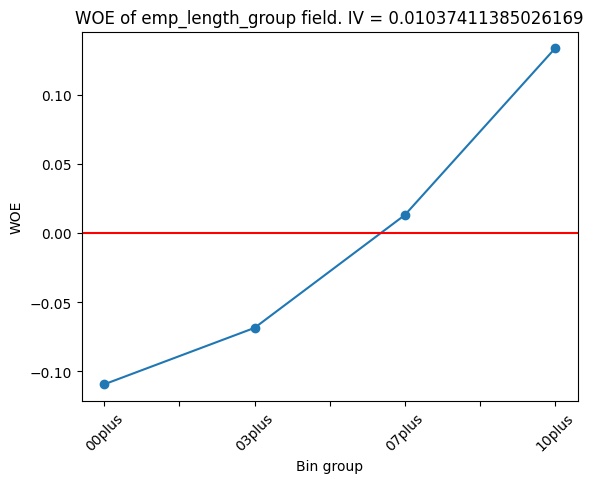

In [44]:
# Chia bin tay
df_summary, IV, thres = bin_table(X_train, y_train, feature='emp_length_group')
print(df_summary)
woe_plot(df_summary, IV)

Information Value of funded_amnt column: 0.0053632413813683695
Information Value of annual_inc column: 0.01460938131353472
Information Value of dti column: 0.03443661911541046
Information Value of revol_bal column: 0.0166755058468114
Information Value of revol_util column: 0.021620908574140413
Information Value of total_rev_hi_lim column: 0.056376620840824496
Information Value of years_from_earliest_cr_line column: 0.029933539620124863
Information Value of term_bin column: 0.02179145851911637
Information Value of delinq_2yrs_bin column: 0.0070419777013496715
Information Value of inq_last_6mths_bin column: 0.05819268835913592
Information Value of emp_length_group column: 0.01037411385026169
Information Value of purpose_group column: 0.05162234007503835


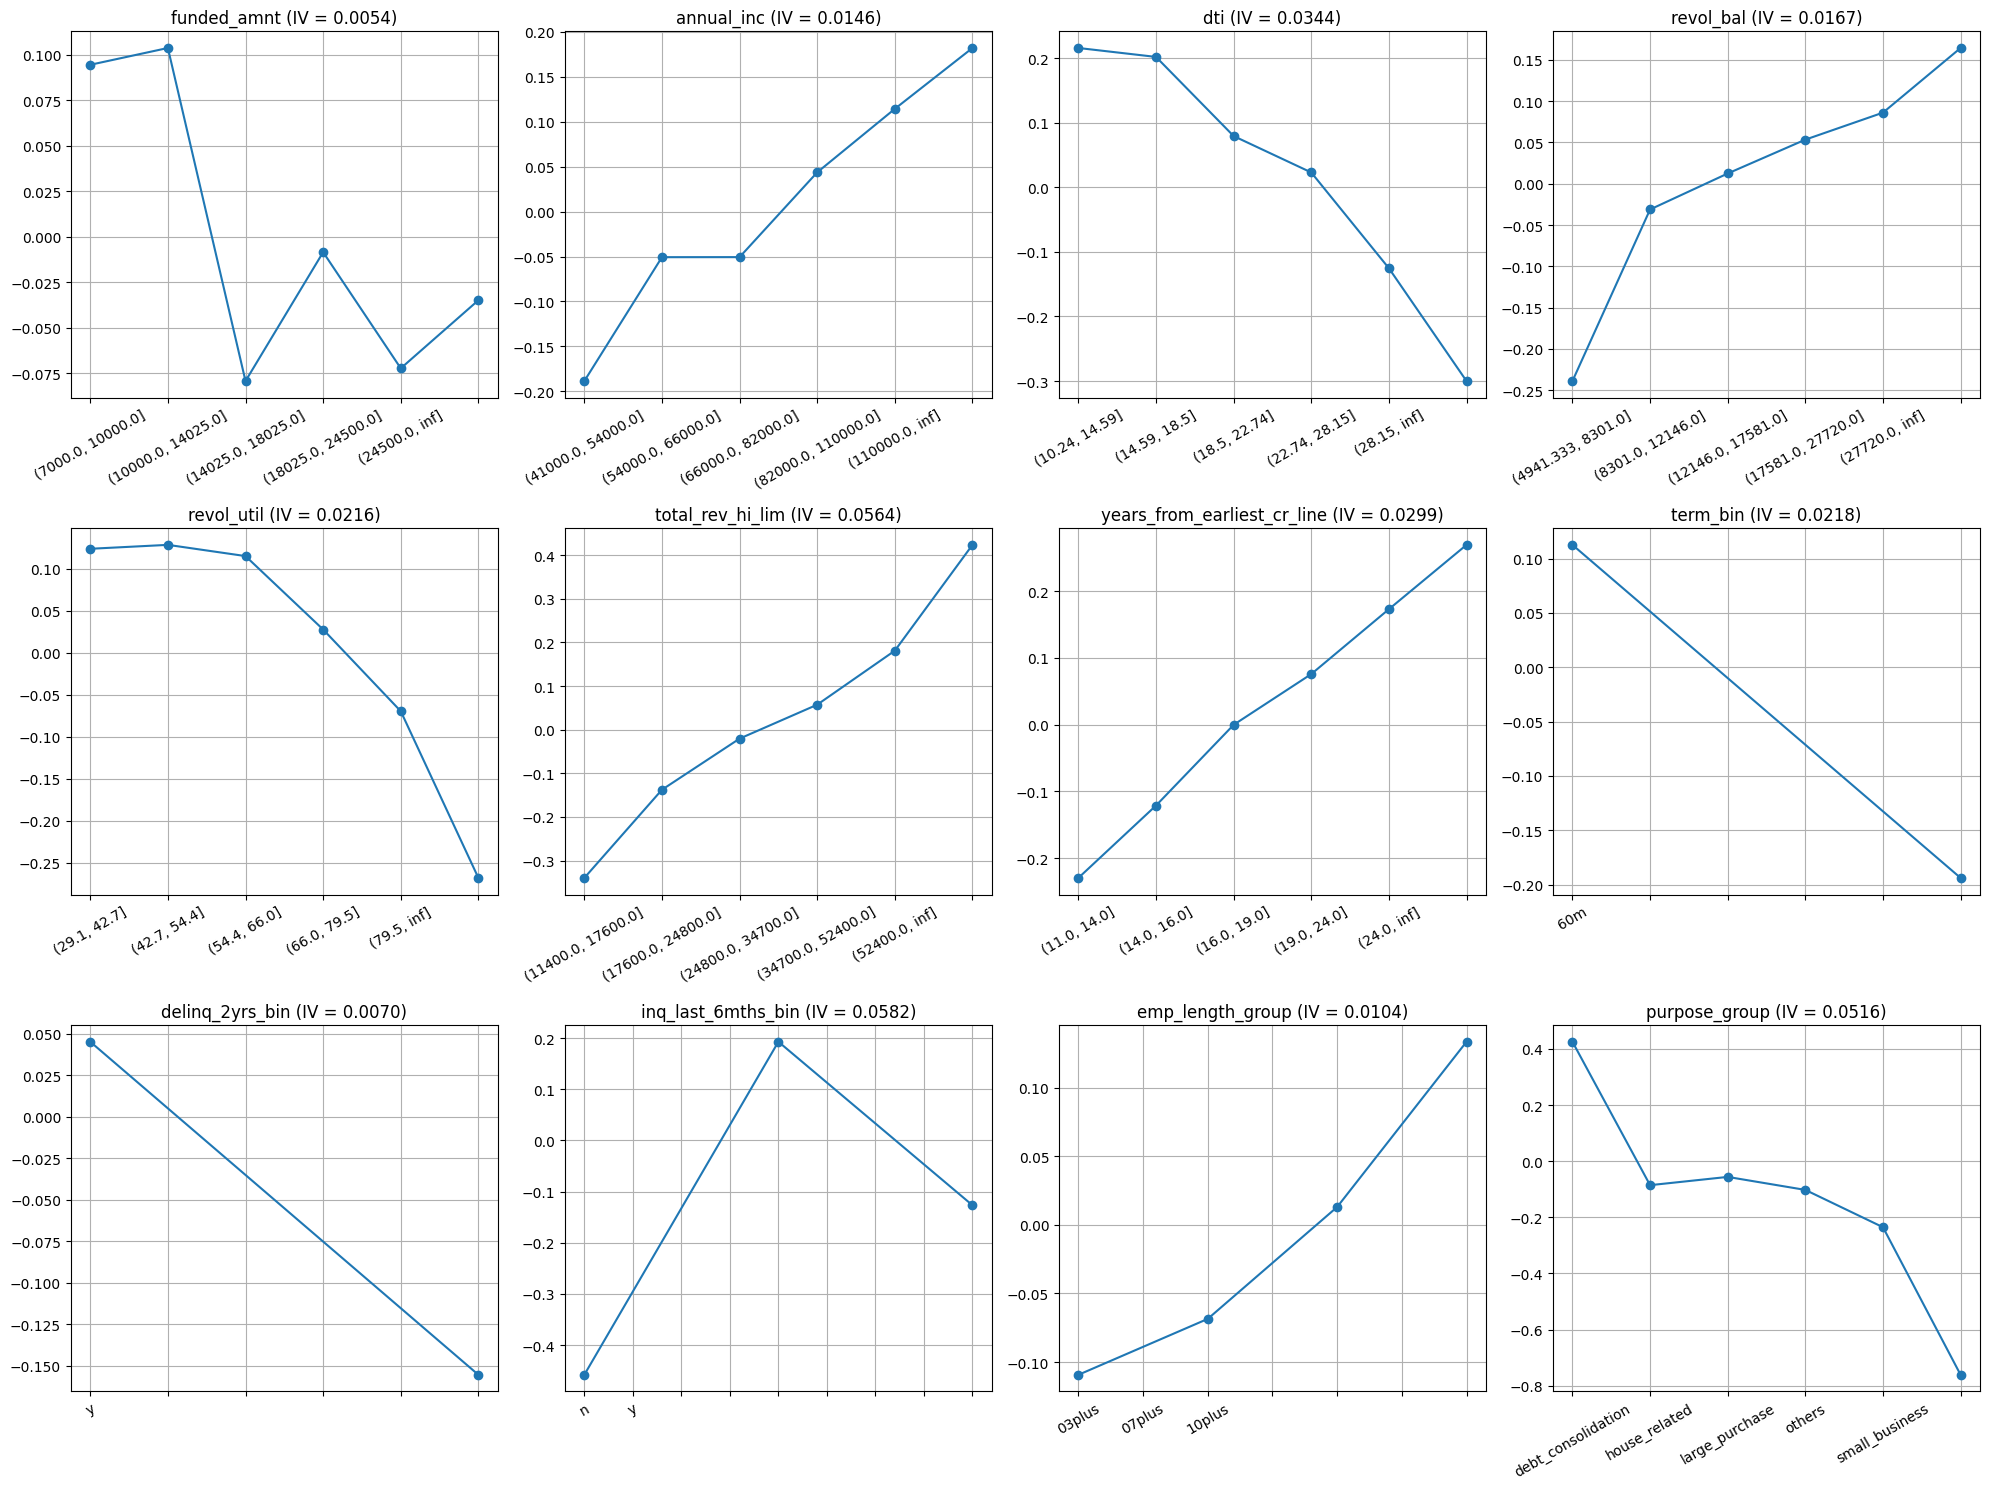

In [45]:
features = X_train.columns.tolist()
n_cols = 4  # số đồ thị mỗi hàng
n_rows = math.ceil(len(features) / n_cols)  # tính số hàng cần

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()  # chuyển về 1D để dễ index

for i, feature in enumerate(features):
    df_summary, IV, thres = bin_table(X_train, y_train, feature)
    WOE_DF = pd.DataFrame(df_summary['WOE']).reset_index()
    WOE_DF.columns = ['bins', 'WOE']
    # Vẽ lên subplot tương ứng
    ax = axes[i]
    ax.plot(WOE_DF['WOE'], linestyle='-', marker='o')
    ax.set_title(f"{feature} (IV = {IV:.4f})")
    ax.set_xticklabels(WOE_DF['bins'], rotation=30)
    ax.grid(True)

# Ẩn các ô trống nếu số lượng biến không chia hết cho 3
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# # Bỏ total_acc vì không có logical trend
# # Bỏ mths_since_last_major_derog vì không có trend hợp lý
# # Bỏ home_ownership vì không có logical trend
# # Bỏ verification_status vì không có logical trend
# # Bỏ pymnt_plan vì chỉ có 1 quan sát 'y'
# # Bỏ initial_list_status vì không có nhiều ý nghĩa về business

#### 3.3.2. Convert to WOE (train data)

In [46]:
WOE_dict=dict()
nbins = {'funded_amnt': 3, 'dti': 6, 'revol_bal': 6, 'total_rev_hi_lim':6, 'years_from_earliest_cr_line':6}
for (col, bins) in nbins.items():
    df_summary, IV, thres = bin_table(X_train, y_train, feature=col, n_bins=bins)
    WOE_dict[col] = {'table':df_summary, 'IV':IV}

Information Value of funded_amnt column: 0.004825451023620088
Information Value of dti column: 0.03443661911541046
Information Value of revol_bal column: 0.0166755058468114
Information Value of total_rev_hi_lim column: 0.056376620840824496
Information Value of years_from_earliest_cr_line column: 0.029933539620124863


In [47]:
# # 'annual_inc', qcut=[MIN_VAL, 40000, 50000, 60000, 72500, 89000, MAX_VAL]
# # 'revol_util', qcut=[MIN_VAL, 47.5, 61.2, 76.5, MAX_VAL]
df_summary, IV, thres = bin_table(X_train, y_train, 'annual_inc', qcut=[MIN_VAL, 52000, 82000, 110000, MAX_VAL])
WOE_dict['annual_inc'] = {'table': df_summary, 'IV': IV}
df_summary, IV, thres = bin_table(X_train, y_train, 'revol_util', qcut=[MIN_VAL, 66, 79.5, MAX_VAL])
WOE_dict['revol_util'] = {'table': df_summary, 'IV': IV}

Information Value of annual_inc column: 0.012411628939600851
Information Value of revol_util column: 0.020515454828599063


In [48]:
for col in ['term_bin', 'delinq_2yrs_bin', 'inq_last_6mths_bin', 'emp_length_group', 'purpose_group']:
    df_summary, IV, thres = bin_table(X_train, y_train, feature=col)
    WOE_dict[col] = {'table':df_summary, 'IV':IV}

Information Value of term_bin column: 0.02179145851911637
Information Value of delinq_2yrs_bin column: 0.0070419777013496715
Information Value of inq_last_6mths_bin column: 0.05819268835913592
Information Value of emp_length_group column: 0.01037411385026169
Information Value of purpose_group column: 0.05162234007503835


In [49]:
columns = []
IVs = []
for col in X_train.columns:
  if col != 'BAD':
    columns.append(col)
    IVs.append(WOE_dict[col]['IV'])
df_WOE = pd.DataFrame({'column': columns, 'IV': IVs})
df_WOE.sort_values('IV', ascending=False)

,column,IV
9,inq_last_6mths_bin,0.058193
5,total_rev_hi_lim,0.056377
11,purpose_group,0.051622
2,dti,0.034437
6,years_from_earliest_cr_line,0.029934
7,term_bin,0.021791
4,revol_util,0.020515
3,revol_bal,0.016676
1,annual_inc,0.012412
10,emp_length_group,0.010374


In [50]:
# Loại 2 features delinq_2yrs_bin, funded_amnt ra khỏi các tập dữ liệu
X_train.drop(columns=['delinq_2yrs_bin', 'funded_amnt'], inplace=True)
X_test.drop(columns=['delinq_2yrs_bin', 'funded_amnt'], inplace=True)

In [51]:
for col in WOE_dict.keys():
    try:
        key = list(WOE_dict[col]['table']['WOE'].index)
        woe = list(WOE_dict[col]['table']['WOE'])
        d = dict(zip(key, woe))
        col_woe = col+'_woe'
        X_train[col_woe] = X_train[col].map(d)
    except:
        print(col)

X_train_woe = X_train.filter(like='_woe', axis = 1)

funded_amnt
delinq_2yrs_bin


In [52]:
X_train_woe

,dti_woe,revol_bal_woe,total_rev_hi_lim_woe,years_from_earliest_cr_line_woe,annual_inc_woe,revol_util_woe,term_bin_woe,inq_last_6mths_bin_woe,emp_length_group_woe,purpose_group_woe
15661,-0.125278,-0.031136,-0.020500,-0.229857,-0.126778,0.098183,0.112641,0.192815,-0.109346,0.425629
372444,0.079538,0.053433,0.181075,0.172820,-0.126778,0.098183,0.112641,-0.126672,0.133736,0.425629
325744,0.079538,-0.031136,-0.020500,0.075592,-0.126778,0.098183,-0.193811,0.192815,-0.109346,-0.235372
23821,0.023128,0.053433,0.181075,-0.229857,0.114172,0.098183,0.112641,-0.126672,0.133736,-0.235372
14266,0.023128,0.086098,0.057279,0.075592,-0.004516,-0.069468,-0.193811,0.192815,-0.068526,0.425629
...,...,...,...,...,...,...,...,...,...,...
6085,0.023128,-0.031136,0.423554,0.075592,-0.126778,0.098183,-0.193811,0.192815,-0.068526,0.425629
157298,-0.300070,0.164407,0.423554,0.269198,0.181843,0.098183,0.112641,0.192815,0.013120,0.425629
103467,0.216006,-0.238910,-0.339739,-0.229857,-0.126778,0.098183,0.112641,0.192815,0.133736,0.425629
225475,0.216006,0.012432,-0.020500,-0.121386,-0.126778,0.098183,0.112641,0.192815,-0.068526,0.425629


#### 3.3.3. Convert to WOE (test data)

In [53]:
WOE_dict=dict()
nbins = {'dti': 6, 'revol_bal': 6, 'total_rev_hi_lim':6, 'years_from_earliest_cr_line':6}
for (col, bins) in nbins.items():
    df_summary, IV, thres = bin_table(X_test, y_test, feature=col, n_bins=bins)
    WOE_dict[col] = {'table':df_summary, 'IV':IV}

# # 'annual_inc', qcut=[MIN_VAL, 40000, 50000, 60000, 72500, 89000, MAX_VAL]
# # 'revol_util', qcut=[MIN_VAL, 47.5, 61.2, 76.5, MAX_VAL]
df_summary, IV, thres = bin_table(X_train, y_train, 'annual_inc', qcut=[MIN_VAL, 52000, 82000, 110000, MAX_VAL])
WOE_dict['annual_inc'] = {'table': df_summary, 'IV': IV}
df_summary, IV, thres = bin_table(X_train, y_train, 'revol_util', qcut=[MIN_VAL, 66, 79.5, MAX_VAL])
WOE_dict['revol_util'] = {'table': df_summary, 'IV': IV}

for col in ['term_bin', 'inq_last_6mths_bin', 'emp_length_group', 'purpose_group']:
    df_summary, IV, thres = bin_table(X_test, y_test, feature=col)
    WOE_dict[col] = {'table':df_summary, 'IV':IV}

columns = []
IVs = []
for col in X_test.columns:
  if col != 'BAD':
    columns.append(col)
    IVs.append(WOE_dict[col]['IV'])
df_WOE = pd.DataFrame({'column': columns, 'IV': IVs})
df_WOE.sort_values('IV', ascending=False)

for col in WOE_dict.keys():
    try:
        key = list(WOE_dict[col]['table']['WOE'].index)
        woe = list(WOE_dict[col]['table']['WOE'])
        d = dict(zip(key, woe))
        col_woe = col+'_woe'
        X_test[col_woe] = X_test[col].map(d)
    except:
        print(col)

X_test_woe = X_test.filter(like='_woe', axis = 1)

Information Value of dti column: 0.034655081337934455
Information Value of revol_bal column: 0.0270237818285657
Information Value of total_rev_hi_lim column: 0.07234708793771308
Information Value of years_from_earliest_cr_line column: 0.03360358889562024
Information Value of annual_inc column: 0.012411628939600851
Information Value of revol_util column: 0.020515454828599063
Information Value of term_bin column: 0.017494931339672195
Information Value of inq_last_6mths_bin column: 0.049495819512799924
Information Value of emp_length_group column: 0.009897883493862662
Information Value of purpose_group column: 0.06502920902332866


## 4. Modeling

### 4.1. Correlation Analysis

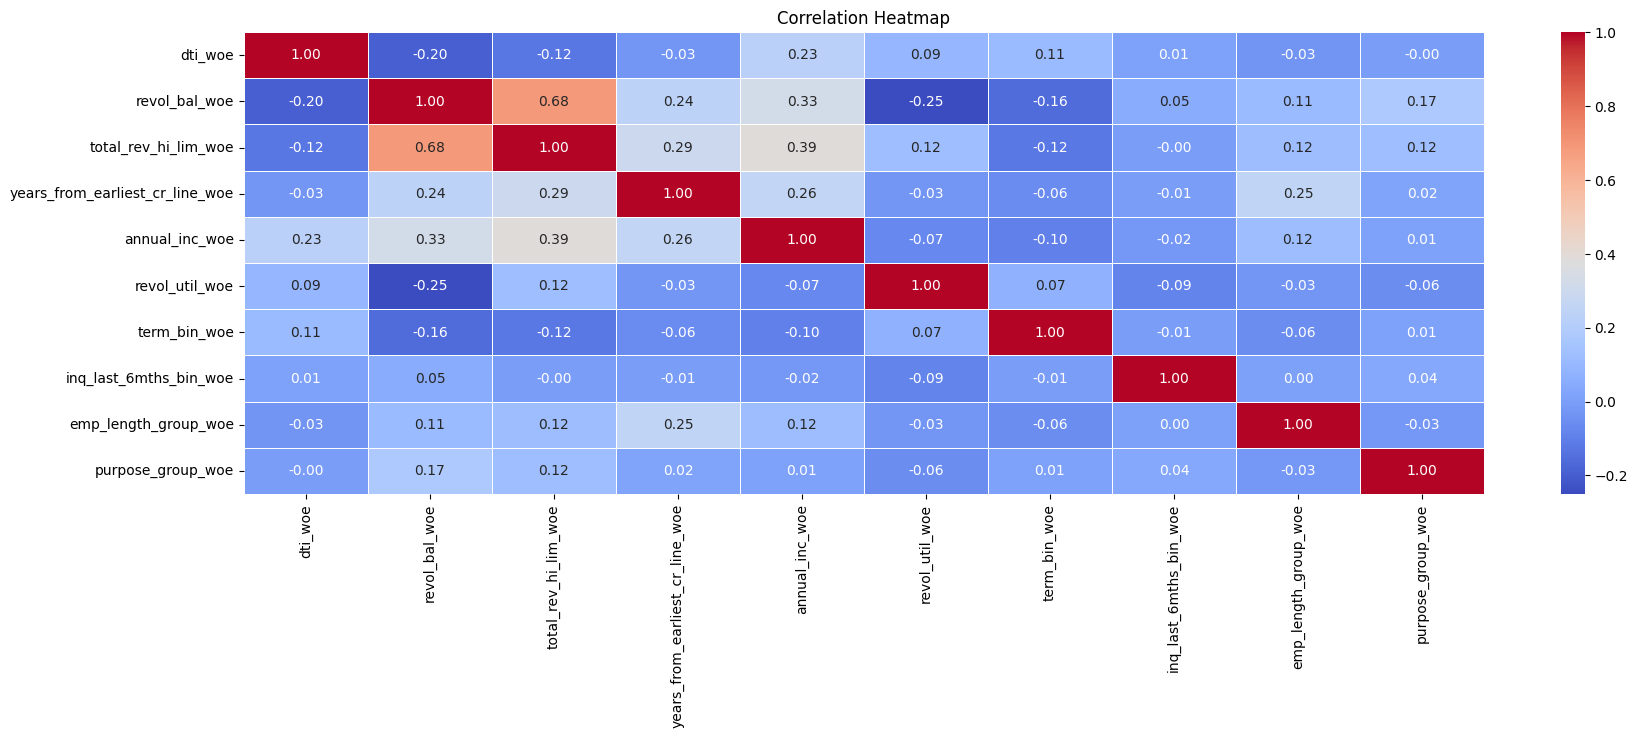

In [54]:
correlation_matrix = X_train_woe.corr()
plt.figure(figsize=(20, 6))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

In [55]:
# Drop cột revol_bal_woe do tương quan cao với revol_rev_hi_lim, đều thể hiện hạn mức tín dụng quay vòng của 1 khách hàng (current revolve balance | current high limit)
X_train_woe.drop(columns=['revol_bal_woe'], inplace=True)
X_test_woe.drop(columns=['revol_bal_woe'], inplace=True)

In [56]:
print(X_train_woe.shape)
print(y_train.shape)
print(X_test_woe.shape)
print(y_test.shape)

(316923, 9)
(316923,)
(79231, 9)
(79231,)


In [57]:
# train_data_saved = pd.concat([X_train_woe, y_train], axis=1)
# train_data_saved.to_csv(path/'data'/'train_data_saved.csv')
# print('saved')
# test_data_saved = pd.concat([X_test_woe, y_test], axis=1)
# test_data_saved.to_csv(path/'data'/'test_data_saved.csv')
# print('saved')

### 4.2. Logistic Regression

#### 4.2.1. Stepwise Selection

In [58]:
def stepwise_selection(X, y, threshold_in=0.01, threshold_out=0.05, verbose=True):
    included = [] # List rỗng đưa vào model
    while True:
        changed = False # Chạy liên tục nếu có biến tiếp tục nhảy ra hoặc vào model

        # Forward step
        excluded = list(set(X.columns) - set(included)) # Đưa toàn bộ biến vào excluded
        new_pvals = pd.Series(index=excluded, dtype=float) # Series p-values

        for new_column in excluded: # Với mỗi column mới ném vào excluded
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit(disp=1) # Chạy logit với biến mới được ném vào, lặp lại mỗi khi thêm 1 biến mới
            new_pvals[new_column] = model.pvalues[new_column] # Lấy p-values mới

        best_pval = new_pvals.min()
        if best_pval < threshold_in: # Nếu p-value thấp nhất nhỏ hơn threshold giữ lại
            best_feature = new_pvals.idxmin() # Thì lấy label của best feature đó
            included.append(best_feature) # Ném ngược vào included
            changed = True # Và đặt changed bằng True để vòng lặp while tiếp tục chạy
            if verbose:
                print(f"--Add {best_feature} with p-value {best_pval:.4f}")

        # Backward step
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=1) # Chạy logit với toàn bộ các biến hiện đang có trong included
        pvalues = model.pvalues.iloc[1:]  # exclude constant 
        worst_pval = pvalues.max() # lấy p-value cao nhất
        if worst_pval > threshold_out: # nếu p-value vượt trên ngưỡng bị ném ra khỏi model
            worst_feature = pvalues.idxmax() # lấy tên biến của p-value đó
            included.remove(worst_feature) # và remove biến đó khỏi include
            changed = True # nếu có biến bị ném ra thì changed = True, vòng while tiếp tục chạy
            if verbose:
                print(f"--Drop {worst_feature} with p-value {worst_pval:.4f}")

        if not changed: # nếu không có biến nào bị ném ra thì break vòng for
            break

    final_model = sm.Logit(y, sm.add_constant(X[included])).fit(disp=1) # chạy model cuối cùng, khi vòng while đã break
    return included, final_model

In [59]:
included, final_model = stepwise_selection(X_train_woe, y_train, threshold_in=0.01, threshold_out=0.01) # Thres 1%

Optimization terminated successfully.
         Current function value: 0.129609
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.128920
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129461
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129269
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129581
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129338
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.128977
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129056
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129446
         Iterations 8
--Add inq_last_6mths_bin_woe with p-value 0.0000
Optimization terminated successfu

#### 4.2.2. Model Summary

In [60]:
final_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Logit
=============================================================================
Model:                  Logit                Method:               MLE       
Dependent Variable:     good_bad             Pseudo R-squared:     0.028     
Date:                   2025-06-13 15:11     AIC:                  79984.3239
No. Observations:       316923               BIC:                  80080.3217
Df Model:               8                    Log-Likelihood:       -39983.   
Df Residuals:           316914               LL-Null:              -41122.   
Converged:              1.0000               LLR p-value:          0.0000    
No. Iterations:         8.0000               Scale:                1.0000    
-----------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------
const                           3.5273   0.0110 320.3350 0.0000 3.5057 3.5489
inq_last_6mths_bin_woe          1.0331   0.0429  24.0921 0.0000 0.9490 1.1171
total_rev_hi_lim_woe            0.8703   0.0498  17.4873 0.0000 0.7728 0.9679
dti_woe                         1.0144   0.0577  17.5733 0.0000 0.9013 1.1276
purpose_group_woe               0.9047   0.0500  18.0783 0.0000 0.8066 1.0028
term_bin_woe                    1.0805   0.0727  14.8647 0.0000 0.9380 1.2229
revol_util_woe                  0.9215   0.0745  12.3764 0.0000 0.7756 1.0674
years_from_earliest_cr_line_woe 0.6675   0.0668   9.9948 0.0000 0.5366 0.7984
emp_length_group_woe            0.7023   0.1101   6.3818 0.0000 0.4866 0.9180
=============================================================================

"""

### 4.3. Validating model

In [61]:
yhat_train = final_model.predict(sm.add_constant(X_train_woe[included])).values
yhat_test = final_model.predict(sm.add_constant(X_test_woe[included])).values

#### 4.3.1. ROC Curve

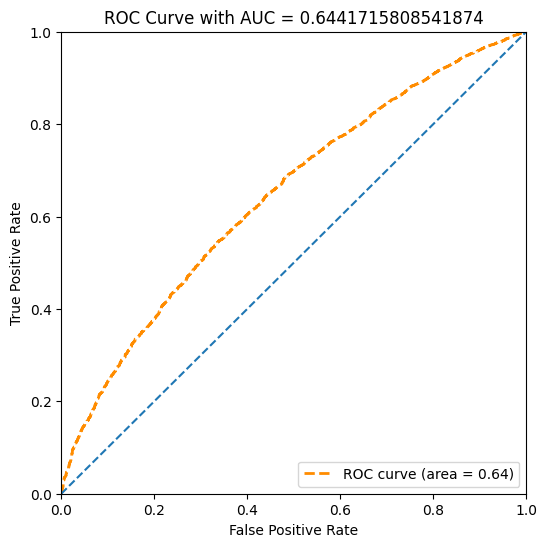

In [62]:
fpr, tpr, thres = roc_curve(y_test, yhat_test)
roc_auc = auc(fpr, tpr)

def _plot_roc_curve(fpr, tpr, thres, auc):
    plt.figure(figsize = (6, 6))
    plt.plot(fpr, tpr, 'b-', color='darkorange', lw=2, linestyle='--', label='ROC curve (area = %0.2f)'%auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve with AUC = {}'.format(roc_auc))
_plot_roc_curve(fpr, tpr, thres, roc_auc)

#### 4.3.2. Precision vs Recall Curve

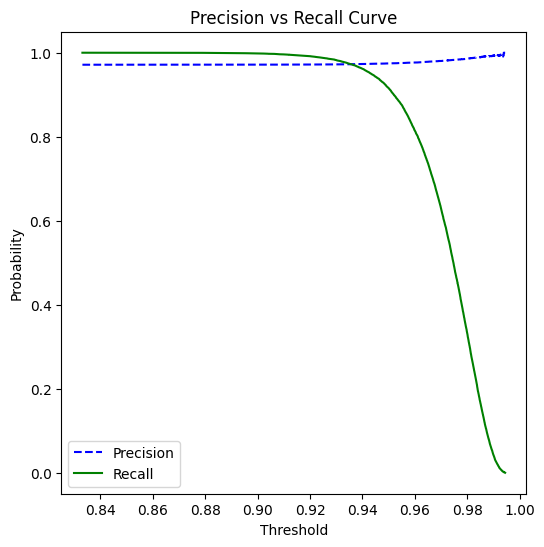

In [63]:
precision, recall, thres = precision_recall_curve(y_test, yhat_test)

def _plot_prec_rec_curve(prec, rec, thres):
    plt.figure(figsize=(6,6))
    plt.plot(thres, prec[:-1], 'b--', label = 'Precision')
    plt.plot(thres, rec[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title('Precision vs Recall Curve')
    plt.legend()

_plot_prec_rec_curve(precision, recall, thres)

#### 4.3.3. KS Test

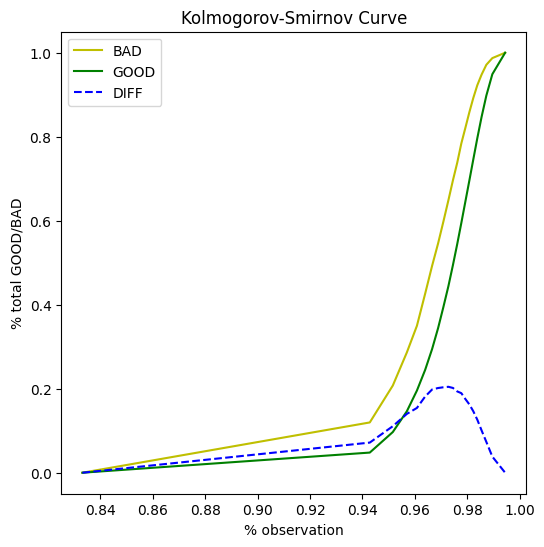

In [64]:
def _KM(y_pred, n_bins):
    _, thresholds = pd.qcut(y_pred, q=n_bins, retbins=True)
    cmd_BAD = []
    cmd_GOOD = []
    BAD_id = set(np.where(y_test == 0)[0])
    GOOD_id = set(np.where(y_test == 1)[0])
    total_BAD = len(BAD_id)
    total_GOOD = len(GOOD_id)
    for thres in thresholds:
      pred_id = set(np.where(y_pred <= thres)[0])
      # Đếm % số lượng hồ sơ BAD có xác suất dự báo nhỏ hơn hoặc bằng thres
      per_BAD = len(pred_id.intersection(BAD_id))/total_BAD
      cmd_BAD.append(per_BAD)
      # Đếm % số lượng hồ sơ GOOD có xác suất dự báo nhỏ hơn hoặc bằng thres
      per_GOOD = len(pred_id.intersection(GOOD_id))/total_GOOD
      cmd_GOOD.append(per_GOOD)
    cmd_BAD = np.array(cmd_BAD)
    cmd_GOOD = np.array(cmd_GOOD)
    return cmd_BAD, cmd_GOOD, thresholds

cmd_BAD, cmd_GOOD, thresholds = _KM(yhat_test, n_bins=20)

def _plot_KM(cmd_BAD, cmd_GOOD, thresholds):
    plt.figure(figsize = (6, 6))
    plt.plot(thresholds, cmd_BAD, 'y-', label = 'BAD')
    plt.plot(thresholds, cmd_GOOD, 'g-', label = 'GOOD')
    plt.plot(thresholds, cmd_BAD-cmd_GOOD, 'b--', label = 'DIFF')
    plt.xlabel('% observation')
    plt.ylabel('% total GOOD/BAD')
    plt.title('Kolmogorov-Smirnov Curve')
    plt.legend()

_plot_KM(cmd_BAD, cmd_GOOD, thresholds)

In [65]:
# Tính KS và p-value của KS
print('KS Test Result:\n', stats.ks_2samp(cmd_BAD, cmd_GOOD))

KS Test Result:
 KstestResult(statistic=np.float64(0.23809523809523808), pvalue=np.float64(0.6028129403170835), statistic_location=np.float64(0.5946314654332376), statistic_sign=np.int8(-1))


#### 4.3.4. VIF Test

In [70]:
# Check collinearity

### 4.4. Monitoring Model

In [66]:
train_result = pd.DataFrame({'SCORE': yhat_train, 'GOOD_BAD': y_train.values})
test_result = pd.DataFrame({'SCORE': yhat_test, 'GOOD_BAD': y_test.values})

#### 4.4.1. PSI

In [67]:
def PSI(reference, validation, score_col, good_bad_col):
   """
   reference and validation both are pd.DataFrame with 2 columns:
   - predicted_col: output prediction of model. score_col: 'your_col_name'
   - actual_col: actual good/bad value from original dataset. good_bad_col: 'your_col_name'
   example: PSI(train_result, test_result, 'PREDICTED', 'ACTUAL')
   """
   # Train data - Actual
   reference.sort_values(by=score_col, ascending=False)
   reference['BIN'], bins = pd.qcut(reference[score_col], 10, retbins=True)
   bins[0] = -np.inf
   bins[-1] = np.inf
   reference['BIN'], bins = pd.cut(reference[score_col], bins=bins, retbins=True)
   df1 = pd.DataFrame(reference.groupby('BIN')[good_bad_col].count())
   df1 = df1.reset_index(drop = True)
   df1['ACTUAL%'] = df1[good_bad_col]/sum(df1[good_bad_col])
   # Test data - Expected
   validation.sort_values(by=score_col, ascending=False)
   validation['BIN'] = pd.cut(validation[score_col], bins=bins)
   df2 = pd.DataFrame(validation.groupby('BIN')[good_bad_col].count())
   df2 = df2.reset_index(drop = True)
   df2['EXPECTED%'] = df2[good_bad_col]/sum(df2[good_bad_col])
   # Gom bảng và tính psi
   df = pd.concat([df1, df2], axis=1)
   df.columns = ('ACTUAL_BIN', 'ACTUAL%', 'EXPECTED_BIN', 'EXPECTED%')
   df['LOWER'] = bins[:-1]
   df['UPPER'] = bins[1:]
   df['ACTUAL% - EXPECTED%'] = df['ACTUAL%'] - df['EXPECTED%']
   df['LN(ACTUAL%/EXPECTED%)'] = np.log(df['ACTUAL%']/df['EXPECTED%'])
   df['PSI'] = df['ACTUAL% - EXPECTED%'] * df['LN(ACTUAL%/EXPECTED%)']
   cols = ['LOWER', 'UPPER'] + [col for col in df.columns if col not in ['LOWER', 'UPPER']]
   df = df[cols]
   psi = df['PSI'].sum()
   return df, psi, bins

psi_output, psi_score, bins = PSI(train_result, test_result, 'SCORE', 'GOOD_BAD')

In [68]:
print('PSI SCORE:',psi_score)
psi_output

PSI SCORE: 0.002948695766425557


,LOWER,UPPER,ACTUAL_BIN,ACTUAL%,EXPECTED_BIN,EXPECTED%,ACTUAL% - EXPECTED%,LN(ACTUAL%/EXPECTED%),PSI
0,-inf,0.951959,31706,0.100043,8139,0.102725,-0.002682,-0.026453,7.093832e-05
1,0.951959,0.961381,31695,0.100009,8367,0.105603,-0.005594,-0.054428,3.044730e-04
2,0.961381,0.967027,31687,0.099983,7921,0.099973,0.000010,0.000098,9.569788e-10
3,0.967027,0.971172,31738,0.100144,7730,0.097563,0.002581,0.026115,6.741170e-05
4,0.971172,0.974606,31665,0.099914,7534,0.095089,0.004825,0.049495,2.388026e-04
5,0.974606,0.977640,31674,0.099942,7509,0.094774,0.005169,0.053103,2.744741e-04
6,0.977640,0.980512,31685,0.099977,7400,0.093398,0.006579,0.068072,4.478591e-04
7,0.980512,0.983449,31692,0.099999,7593,0.095834,0.004165,0.042546,1.772203e-04
8,0.983449,0.986873,31728,0.100113,8219,0.103735,-0.003622,-0.035540,1.287267e-04
9,0.986873,inf,31653,0.099876,8819,0.111307,-0.011431,-0.108367,1.238789e-03


#### 4.4.2. CSI

In [69]:
# CSI = 1 — |Coefficients Current / Coefficients Baseline|

## 5. Xây dựng Scorecard

In [71]:
# Dev function convert prob and woe to score ranges but I don't want to
def _CreditScore(beta, alpha, woe, n = 12, odds = 1/60, pdo = -50, thres_score = 1000):
    factor = pdo/np.log(2)
    offset = thres_score - factor*np.log(odds)
    score = (beta*woe+alpha/n)*factor+offset/n
    return score

## 6. References

1. Siddiqi, N. (2006). *Credit Risk Scorecards: Developing and Implementing Intelligent Credit Scoring*. Wiley Finance.  
2. Khanh, Pham Dinh (2020). *Scorecard Model*. Khanh's Blog. [https://phamdinhkhanh.github.io/2020/01/17/ScoreCard.html]